**Set Credentials Information**

The library reads VDC credentials from environment variables. We provide a utility for interactively saving credentials for a session, but it is convenient to do this manually in a notebook.

In [1]:
%env VDC_CREDENTIALS=dsvdc:4T34c80I8q9E
%env VDC_SOCKET=155.98.19.235:27017

env: VDC_CREDENTIALS=dsvdc:4T34c80I8q9E
env: VDC_SOCKET=155.98.19.235:27017


**Library Imports**

In [2]:
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pydsvdc import DsVdc
from datetime import timedelta
import sys



**Initialize library**

The DsVDC library can take a DataSpaces connection string for connectivity over WAN. DataSpaces can also pick up a local configuration file automatically. This is useful for RDMA-based interconnect or many servers. In this case, we've set environment variables ahead of time.

In [3]:
dv = DsVdc()

### Query 1
"Visualize the upper-right quadrant of PACUS radiance data on Channel 3 nearest in time to midnight August 2, 2020."

**Query Timestep**

The nature of the query depends on the provided arguments. Providing a `name` and a `time` will query for the nearest data in time for the named variable. `lb` and `ub` will subset that data (in the server). The form of `name` is forward-slash separated values. It starts with a product identifier (e.g. FDCC, RadC, RadM) and ends with a variable name (e.g. Rad, Mask, etc.). The intermediate contents of the name are product-dependent: RadX will include a channel (C01, C02, etc), and RadM will additionally contain a zone (M1 or M2).

In this case, find the closest available data to `timestamp` (midnight August 2, 2020) on RadC Channel 3. Fetch the Rad variable from that dataset in the range (0,2500) to (1499, 4999) (overall data shape is 3000x5000 pixels. We choose this subset to focus on the West Coast.

The return value is a list of tuples of the form:

`(timestamp, ndarray of data [, metadata])`

In this case, a single result will be returned, so we fetch the first tuple and examine the second element of the tuple (the data payload).

In [4]:
timestamp = '202008020000'
channel = 3
lb = (0,2500)
ub = (1499,4999)

qres = dv.query(name = f'RadC/C{channel:02d}/Rad', time = timestamp, lb=lb, ub=ub)
radiance = qres[0][1] # query returns a list of tuples of form (timestamp, ndarray)

**Calculate Reflectance from Radiance**

In [5]:
# Define some constants needed for the conversion. From the pdf linked above
Esun_Ch_01 = 726.721072
Esun_Ch_02 = 663.274497
Esun_Ch_03 = 441.868715
d2 = 0.3
# Apply the formula to convert radiance to reflectance
ref = (radiance * np.pi * d2) / Esun_Ch_02

# Make sure all data is in the valid data range
ref = np.maximum(ref, 0.0)
ref = np.minimum(ref, 1.0)

# Apply the formula to adjust reflectance gamma
ref_gamma = np.sqrt(ref)

**Visualize Reflectance**

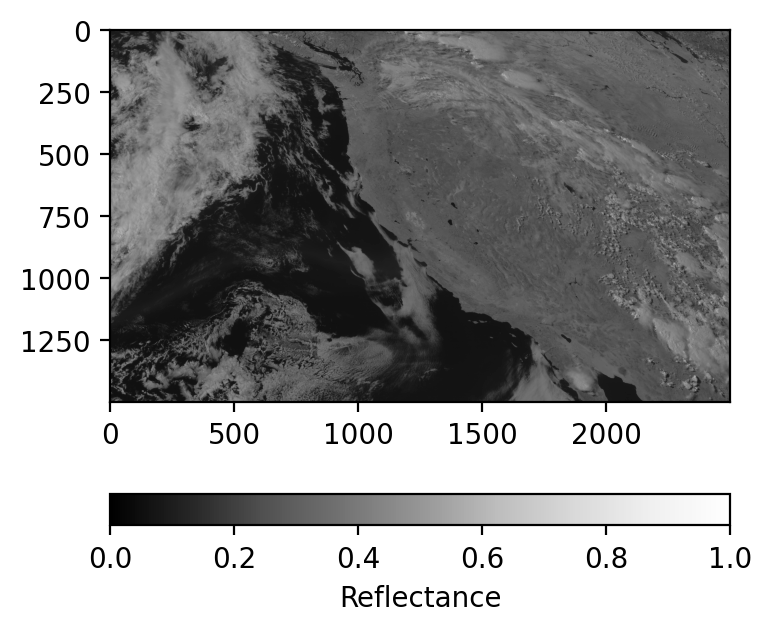

In [6]:
# Plot gamma adjusted reflectance
fig = plt.figure(figsize=(4,4),dpi=200)
im = plt.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Reflectance')
plt.show()

### Query 2:
Overlay active fire area data over reflectance for the reading at which fire was most prevalent.

This will involve two queries. The first will collect the fire area data, querying for a pixel map (the FDCC Area variable) of fire data with the highest number of active fire area pixels (the `total_number_of_pixels_with_fire_area` variable). It will use the timestamp of that data to subsequently query for radiance data (offset by 6 hours for visibility).

**Query maximum fire area pixels**
"Find the Mask data for the FDCC reading that corresponds to the maximal value of `total_number_of_pixels_with_fire_area` in the range of May 1 to October 31, 2020."

If the query includes `name`, `start_time`, `end_time`, and `find_max`/`find_min` parameters, the query will find where the `find_max`/`find_min` value is maximized/minimized for the product identifier indicated by the `name` value.

Along with the data, we recover the timestamp of that data and the actual extreme value of `total_number_of_pixels_with_fire_area`.

In [7]:
lb = (0,1250)
ub = (749,2499)

qres = dv.query(name = f'FDCC/Mask', start_time = '202005010000', end_time = '202010312359', find_max = 'total_number_of_pixels_with_fire_area', lb=lb, ub=ub)
(tstamp, mask, max_pixels) = qres[0] # query returns a list of tuples of form (timestamp, ndarray, tags...)
print(f'Maximum of {int(max_pixels)} pixels seen with fire area at {tstamp}')

Maximum of 504 pixels seen with fire area at 2020-09-09 04:01:17


**Query (nearly) coincident radiance**
"Find the RadC Channel 3 radiance data at the given timestamp."

Query for the timestamp we got in the first query (but offset by 6 hours so it's not night-time).

In [8]:
lb = (lb[0]*2, lb[1]*2)
ub = (ub[0]*2+1, ub[1]*2+1)
qres = dv.query(name = f'RadC/C3/Rad', time = tstamp - timedelta(hours=6), lb=lb, ub=ub)
(tstamp, radiance) = qres[0] 

**Calculate reflectance**

In [9]:
# Define some constants needed for the conversion. From the pdf linked above
Esun_Ch_01 = 726.721072
Esun_Ch_02 = 663.274497
Esun_Ch_03 = 441.868715
d2 = 0.3
# Apply the formula to convert radiance to reflectance
ref = (radiance * np.pi * d2) / Esun_Ch_02

# Make sure all data is in the valid data range
ref = np.maximum(ref, 0.0)
ref = np.minimum(ref, 1.0)

# Apply the formula to adjust reflectance gamma
ref_gamma = np.sqrt(ref)

**Construct a grid of fire locations**

In [10]:
fire_pixels = np.zeros(radiance.shape)
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if mask[i][j] == 30:
            idx = (slice(2*i,2*i+40), slice(2*j,2*j+40))
            fire_pixels[idx] = .7
fire_pixels = np.ma.masked_where(fire_pixels == 0,fire_pixels)

**Visualize fire on reflectance**

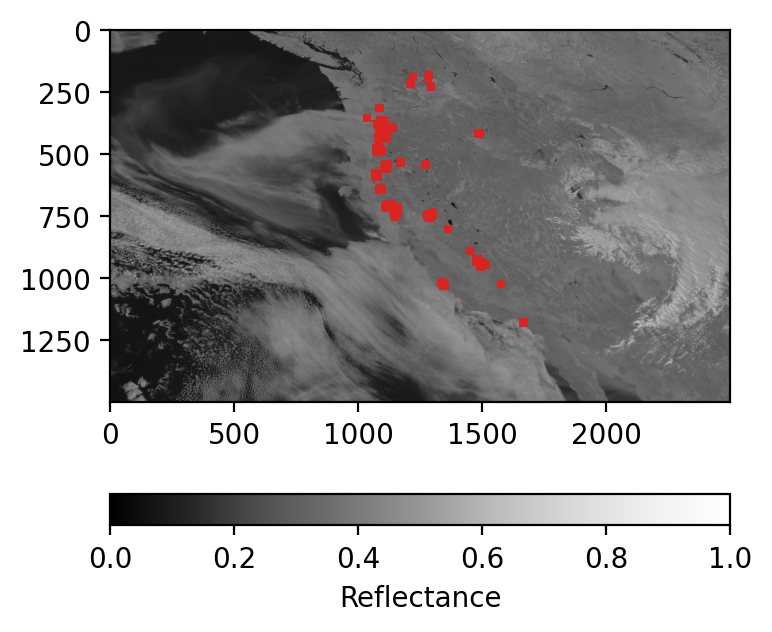

In [11]:
# Plot gamma adjusted reflectance
fig = plt.figure(figsize=(4,4),dpi=200)
im = plt.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
im2 = plt.imshow(fire_pixels, vmin=0.0, vmax=1.0, cmap='Reds')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Reflectance')
plt.show()